In [22]:
import numpy as np 
import pandas as pd
import pandas.io.sql as sqlio
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2 as ps

In [23]:
conn = ps.connect(dbname="Capstone_Project",
                  user="postgres",
                  password="12345",
                  port = "5432")

# **KATEGORİ BAZLI ÜRÜN ANALİZİ**

In [24]:
sql = """SELECT c.category_name, 
       ROUND(SUM(od.total_price)::numeric, 0) AS total_sales
FROM order_details od
JOIN products p ON od.product_id = p.product_id
JOIN categories c ON p.category_id = c.category_id
GROUP BY c.category_name
ORDER BY total_sales DESC """

In [25]:
df = sqlio.read_sql_query(sql, conn)
df.head(8)

C:\Users\GökçeKoray\AppData\Local\Temp\ipykernel_31340\1435730981.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql, conn)


,category_name,total_sales
0,Beverages,286527.0
1,Dairy Products,251331.0
2,Meat/Poultry,178189.0
3,Confections,177099.0
4,Seafood,141623.0
5,Condiments,113695.0
6,Produce,105269.0
7,Grains/Cereals,100727.0


C:\Users\GökçeKoray\AppData\Local\Temp\ipykernel_31340\339544561.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category_name', y='total_sales', data=df, palette='viridis')


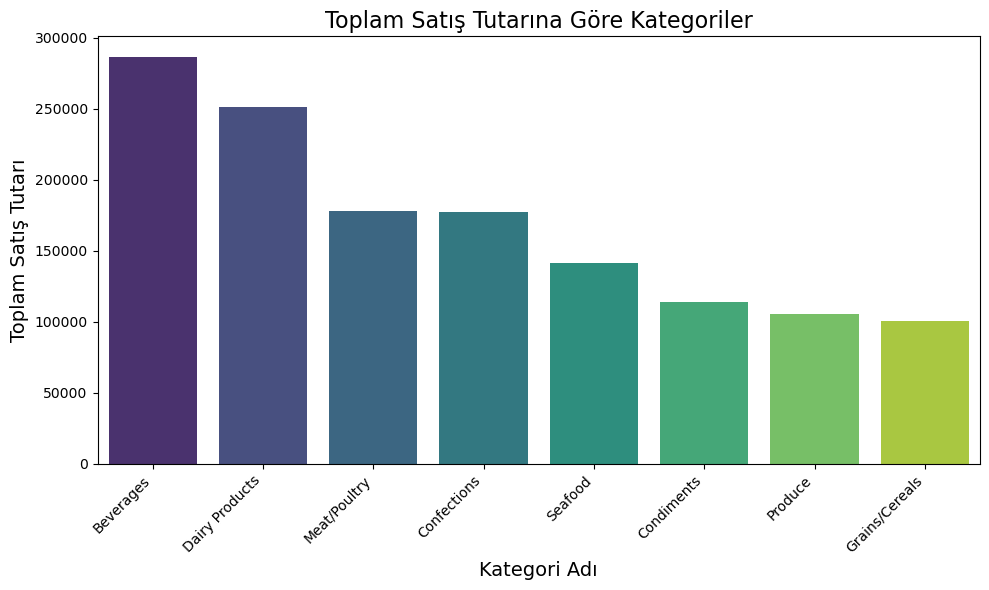

In [26]:
# Bar grafiği için seaborn ve matplotlib kullanarak görselleştirme
plt.figure(figsize=(10,6))
sns.barplot(x='category_name', y='total_sales', data=df, palette='viridis')

# Başlık ve etiketler ekleyelim
plt.title('Toplam Satış Tutarına Göre Kategoriler', fontsize=16)
plt.xlabel('Kategori Adı', fontsize=14)
plt.ylabel('Toplam Satış Tutarı', fontsize=14)

# x eksenindeki etiketleri döndürme (okunabilirlik için)
plt.xticks(rotation=45, ha='right')

# Grafiği göster
plt.tight_layout()
plt.show()

**Yukarıda verilen analizde kategorilere göre toplam satış miktarı hesaplanmıştır. En çok satışın "Beverages" yani İçecekler kategoerisinde en az satışın ise "Grains/Cereals" yani Tahıl grubunun oluşturduğu görülmektedir.**

In [27]:
sql1 = """WITH ranked_products AS (
    SELECT 
        c.category_name,
        p.product_name,
        ROUND(SUM(od.total_price)::numeric, 0) AS total_sales,
        DENSE_RANK() OVER (PARTITION BY c.category_name ORDER BY SUM(od.total_price) DESC) AS rank_by_sales
    FROM order_details od
    JOIN products p ON od.product_id = p.product_id
    JOIN categories c ON p.category_id = c.category_id
    GROUP BY c.category_name, p.product_name
)
SELECT 
    category_name,
    product_name,
    total_sales
FROM ranked_products
WHERE rank_by_sales = 1
ORDER BY total_sales DESC"""

In [28]:
df = sqlio.read_sql_query(sql1, conn)
df.head(8)

C:\Users\GökçeKoray\AppData\Local\Temp\ipykernel_31340\1256851012.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql1, conn)


,category_name,product_name,total_sales
0,Beverages,Côte de Blaye,149984.0
1,Meat/Poultry,Thüringer Rostbratwurst,87736.0
2,Dairy Products,Raclette Courdavault,76296.0
3,Confections,Tarte au sucre,49828.0
4,Grains/Cereals,Gnocchi di nonna Alice,45121.0
5,Produce,Manjimup Dried Apples,44743.0
6,Seafood,Carnarvon Tigers,31988.0
7,Condiments,Vegie-spread,17696.0


C:\Users\GökçeKoray\AppData\Local\Temp\ipykernel_31340\1664770206.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='product_name', y='total_sales', data=df, palette='viridis')


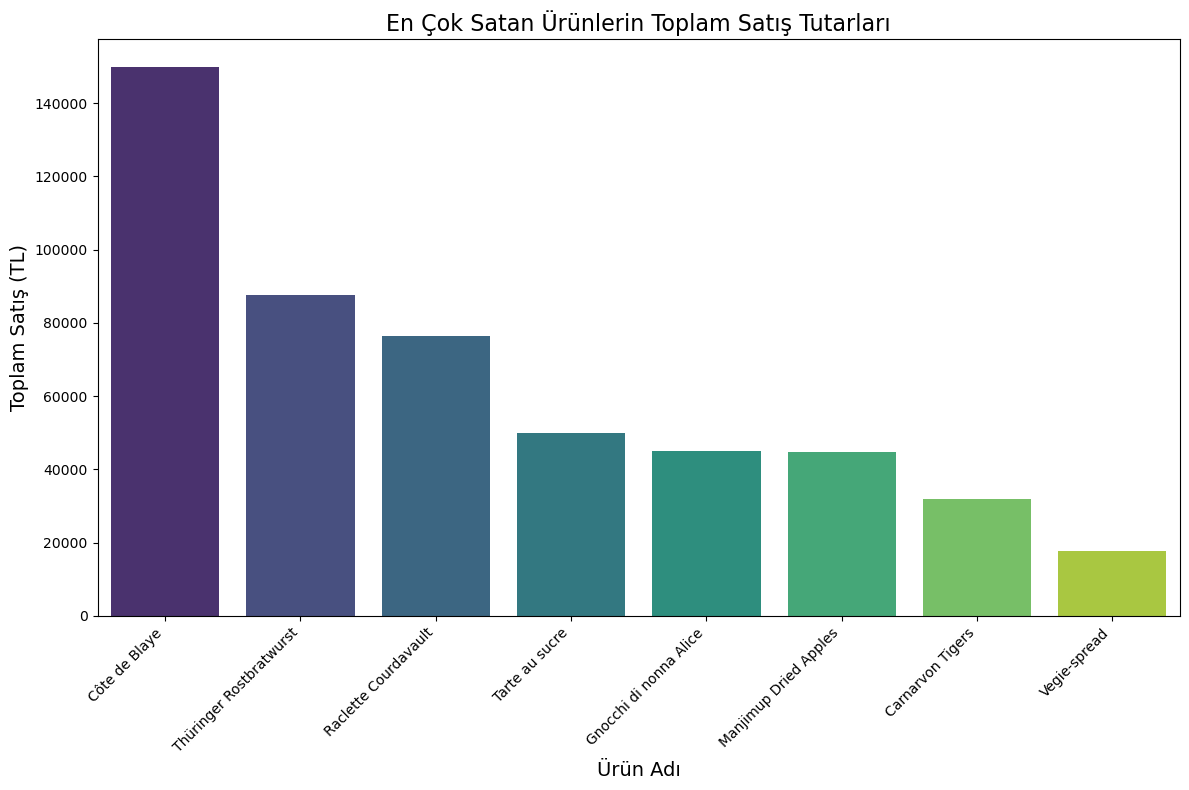

In [29]:
# Bar grafiği için seaborn ve matplotlib kullanarak görselleştirme
plt.figure(figsize=(12, 8))  # Grafiğin boyutlarını ayarlayalım
sns.barplot(x='product_name', y='total_sales', data=df, palette='viridis')

# Başlık ve etiketler ekleyelim
plt.title('En Çok Satan Ürünlerin Toplam Satış Tutarları', fontsize=16)
plt.xlabel('Ürün Adı', fontsize=14)
plt.ylabel('Toplam Satış (TL)', fontsize=14)

# x eksenindeki etiketleri döndürme (okunabilirlik için)
plt.xticks(rotation=45, ha='right')

# Grafiği göster
plt.tight_layout()
plt.show()

**Yukarıda verilen analizde kategori bazında belirlenen kategorinin en çok satılan ürünü toplam satış miktarına göre hesaplanmıştır. En çok satışın "Beverages" kategorisinden "Cote de Blaye" isimli bir şarap, en az satışın ise "Condiments" yani baharat kategorisinden "Vegie-spread" adlı baharat olmuştur.**"

# **PERFORMANS ANALİZİ**

In [35]:
sql2 = """
WITH yearly_monthly_sales AS (
    SELECT
        EXTRACT(YEAR FROM o.order_date) AS year,
        EXTRACT(MONTH FROM o.order_date) AS month,
        COUNT(DISTINCT o.order_id) AS order_count,
        ROUND(SUM(od.total_price)::numeric, 2) AS total_revenue
    FROM 
        orders o
    JOIN 
        order_details od ON o.order_id = od.order_id
    WHERE 
        EXTRACT(YEAR FROM o.order_date) IN (1997, 1998)
    GROUP BY 
        year, month
),
sales_comparison AS (
    SELECT 
        m1.month,
        m1.order_count AS order_count_1997,
        m2.order_count AS order_count_1998,
        (m2.order_count - m1.order_count) AS order_count_diff,
        m1.total_revenue AS revenue_1997,
        m2.total_revenue AS revenue_1998,
        (m2.total_revenue - m1.total_revenue) AS revenue_diff
    FROM 
        yearly_monthly_sales m1
    LEFT JOIN 
        yearly_monthly_sales m2 ON m1.month = m2.month AND m2.year = 1998
    WHERE 
        m1.year = 1997
),
growth_calculation AS (
    SELECT 
        month,
        order_count_1997,
        order_count_1998,
        order_count_diff,
        revenue_1997,
        revenue_1998,
        revenue_diff,
        CASE 
            WHEN order_count_1997 > 0 THEN ROUND(((order_count_1998 - order_count_1997) * 100.0 / order_count_1997), 2)
            ELSE NULL
        END AS order_count_growth_percentage,
        CASE 
            WHEN revenue_1997 > 0 THEN ROUND(((revenue_1998 - revenue_1997) * 100.0 / revenue_1997), 2)
            ELSE NULL
        END AS revenue_growth_percentage
    FROM 
        sales_comparison
)
SELECT 
    month,
    order_count_1997,
    order_count_1998,
    order_count_diff,
    order_count_growth_percentage,
    revenue_1997,
    revenue_1998,
    revenue_diff,
    revenue_growth_percentage
FROM 
    growth_calculation
WHERE 
    order_count_1998 IS NOT NULL
ORDER BY 
    month;
"""

In [39]:
df = sqlio.read_sql_query(sql2, conn)
df.head()

C:\Users\GökçeKoray\AppData\Local\Temp\ipykernel_31340\1231714243.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql2, conn)


,month,order_count_1997,order_count_1998,order_count_diff,order_count_growth_percentage,revenue_1997,revenue_1998,revenue_diff,revenue_growth_percentage
0,1.0,33,55,22,66.67,66692.80,100854.72,34161.92,51.22
1,2.0,29,54,25,86.21,41207.20,104561.95,63354.75,153.75
2,3.0,30,73,43,143.33,39979.90,109825.45,69845.55,174.70
3,4.0,31,74,43,138.71,55699.39,134630.56,78931.17,141.71
4,5.0,32,14,-18,-56.25,56823.70,19898.66,-36925.04,-64.98


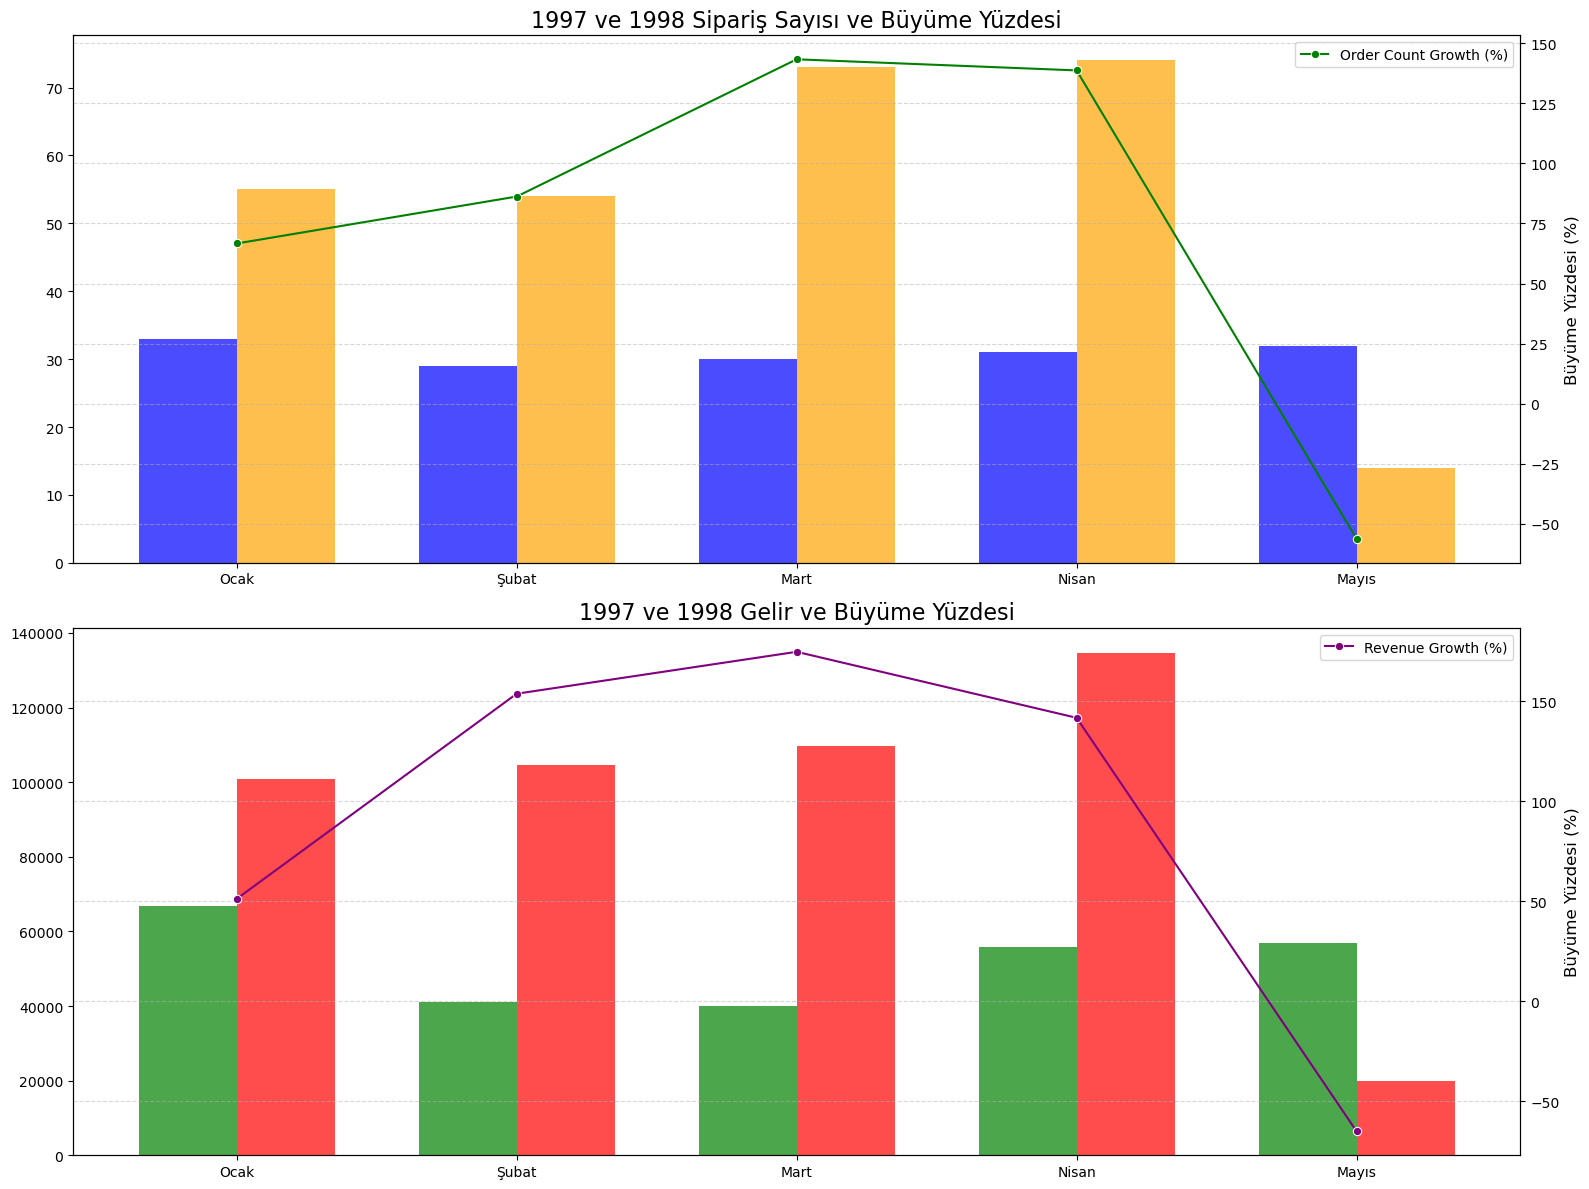

In [41]:
months = ['Ocak', 'Şubat', 'Mart', 'Nisan', 'Mayıs', 'Haziran', 
          'Temmuz', 'Ağustos', 'Eylül', 'Ekim', 'Kasım', 'Aralık']
df['month_name'] = df['month'].apply(lambda x: months[int(x) - 1])

plt.figure(figsize=(16, 12))

# 1. Grafik: Order Count ve Order Count Growth
plt.subplot(2, 1, 1)
x = df['month']

# Sipariş Sayısı Bar Grafikleri
bar_width = 0.35
plt.bar(x - bar_width / 2, df['order_count_1997'], width=bar_width, label='1997 Order Count', color='b', alpha=0.7)
plt.bar(x + bar_width / 2, df['order_count_1998'], width=bar_width, label='1998 Order Count', color='orange', alpha=0.7)

# Büyüme Yüzdesi Çizgi Grafiği
ax1 = plt.gca().twinx()
sns.lineplot(x=x, y=df['order_count_growth_percentage'], marker='o', color='green', label='Order Count Growth (%)', ax=ax1)

# Ayarlar
plt.title('1997 ve 1998 Sipariş Sayısı ve Büyüme Yüzdesi', fontsize=16)
plt.xlabel('Ay', fontsize=12)
plt.xticks(x, df['month_name'], rotation=45)
plt.ylabel('Sipariş Sayısı', fontsize=12)
ax1.set_ylabel('Büyüme Yüzdesi (%)', fontsize=12)
plt.legend(loc='upper left')
ax1.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Grafik: Revenue ve Revenue Growth
plt.subplot(2, 1, 2)

# Gelir Bar Grafikleri
plt.bar(x - bar_width / 2, df['revenue_1997'], width=bar_width, label='1997 Revenue', color='g', alpha=0.7)
plt.bar(x + bar_width / 2, df['revenue_1998'], width=bar_width, label='1998 Revenue', color='red', alpha=0.7)

# Büyüme Yüzdesi Çizgi Grafiği
ax2 = plt.gca().twinx()
sns.lineplot(x=x, y=df['revenue_growth_percentage'], marker='o', color='purple', label='Revenue Growth (%)', ax=ax2)

# Ayarlar
plt.title('1997 ve 1998 Gelir ve Büyüme Yüzdesi', fontsize=16)
plt.xlabel('Ay', fontsize=12)
plt.xticks(x, df['month_name'], rotation=45)
plt.ylabel('Gelir (USD)', fontsize=12)
ax2.set_ylabel('Büyüme Yüzdesi (%)', fontsize=12)
plt.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**Performans değerlerndirmesini incelediğimiz zaman 1998 yılında sipariş miktarında ve toplam gelirde iki farklı yılın aynı aylarında (mayıs hariç) sürekli artış görülmüşütr. Mayıs ayındaki düşüş ise gerçeği yanstmamaktadır. 1998 mayıs ayına ait verilerde eksiklik olmasından kaynaklanmaktır.**